**Transfer learning from pretrained model using Keras.**

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import backend as K 

### Train data

In [2]:
ann_file = 'input/train2019.json'
with open(ann_file) as data_file:
        train_anns = json.load(data_file)

In [3]:
train_anns_df = pd.DataFrame(train_anns['annotations'])[['image_id','category_id']]
train_img_df = pd.DataFrame(train_anns['images'])[['id', 'file_name']].rename(columns={'id':'image_id'})
df_train_file_cat = pd.merge(train_img_df, train_anns_df, on='image_id')
df_train_file_cat['category_id']=df_train_file_cat['category_id'].astype(str)
df_train_file_cat.head()

,image_id,file_name,category_id
0,0,train_val2019/Plants/400/d1322d13ccd856eb4236c...,400
1,1,train_val2019/Plants/570/15edbc1e2ef000d8ace48...,570
2,2,train_val2019/Reptiles/167/c87a32e8927cbf4f06d...,167
3,3,train_val2019/Birds/254/9fcdd1d37e96d8fd94dfdc...,254
4,4,train_val2019/Plants/739/ffa06f951e99de9d220ae...,739


In [4]:
len(df_train_file_cat['category_id'].unique())

1010

/var/folders/wj/ptff1vp12y59z_rr8m2h5r040000gn/T/ipykernel_32186/1265792985.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  img_names = df_train_file_cat[df_train_file_cat['category_id']=='400']['file_name'][:30]
[ WARN:0@656.948] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('input/train2019/train_val2019/Plants/400/d1322d13ccd856eb4236c8b888546c79.jpg'): can't open/read file: check file path/integrity


TypeError: Image data of dtype object cannot be converted to float

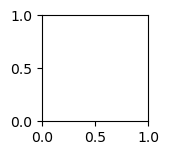

### Validation data

In [6]:
valid_ann_file = '../input/inaturalist-2019-fgvc6/val2019.json'
with open(valid_ann_file) as data_file:
        valid_anns = json.load(data_file)

In [7]:
valid_anns_df = pd.DataFrame(valid_anns['annotations'])[['image_id','category_id']]
valid_anns_df.head()

,image_id,category_id
0,265213,644
1,265214,597
2,265215,883
3,265216,300
4,265217,881


In [8]:
valid_img_df = pd.DataFrame(valid_anns['images'])[['id', 'file_name']].rename(columns={'id':'image_id'})
valid_img_df.head()

,image_id,file_name
0,265213,train_val2019/Plants/644/716a69838526f3ada3b2f...
1,265214,train_val2019/Plants/597/0942cc64d2e759c5ee059...
2,265215,train_val2019/Plants/883/acfdbfd9fa675f1c84558...
3,265216,train_val2019/Birds/300/5f3194ff536c7dd31d80b7...
4,265217,train_val2019/Plants/881/76acaf0b2841f91982d21...


In [9]:
df_valid_file_cat = pd.merge(valid_img_df, valid_anns_df, on='image_id')
df_valid_file_cat['category_id']=df_valid_file_cat['category_id'].astype(str)
df_valid_file_cat.head()

,image_id,file_name,category_id
0,265213,train_val2019/Plants/644/716a69838526f3ada3b2f...,644
1,265214,train_val2019/Plants/597/0942cc64d2e759c5ee059...,597
2,265215,train_val2019/Plants/883/acfdbfd9fa675f1c84558...,883
3,265216,train_val2019/Birds/300/5f3194ff536c7dd31d80b7...,300
4,265217,train_val2019/Plants/881/76acaf0b2841f91982d21...,881


In [10]:
nb_classes = 1010
batch_size = 64
img_size = 80
nb_epochs = 30

In [11]:
%%time
train_datagen=ImageDataGenerator(rescale=1./255, 
    validation_split=0.25,
    horizontal_flip = True,    
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range=0.3
    )

train_generator=train_datagen.flow_from_dataframe(
    dataframe=df_train_file_cat,
    directory="../input/inaturalist-2019-fgvc6/train_val2019",
    x_col="file_name",
    y_col="category_id",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",    
    target_size=(img_size,img_size))

Found 265213 images belonging to 1010 classes.
CPU times: user 5.7 s, sys: 8.5 s, total: 14.2 s
Wall time: 1min 39s


In [12]:
%%time
test_datagen = ImageDataGenerator(rescale=1./255)

valid_generator=test_datagen.flow_from_dataframe(
    dataframe=df_valid_file_cat,
    directory="../input/inaturalist-2019-fgvc6/train_val2019",
    x_col="file_name",
    y_col="category_id",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",    
    target_size=(img_size,img_size))

Found 3030 images belonging to 1010 classes.
CPU times: user 76 ms, sys: 88 ms, total: 164 ms
Wall time: 1.16 s


### Model

In [13]:
model = applications.Xception(weights='imagenet', 
                              include_top=False, 
                              input_shape=(img_size, img_size, 3))
#model.load_weights('../input/NASNet-large-no-top/NASNet-large-no-top.h5')
#model.summary()

Instructions for updating:
Colocations handled automatically by placer.
83689472/83683744 [==============================] - 2s 0us/step


In [14]:
# Freeze last 5 layers
for layer in model.layers[:-5]:
    layer.trainable = False

In [15]:
#Adding custom layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(nb_classes, activation="softmax")(x)
model_final = Model(input = model.input, output = predictions)

model_final.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


In [16]:
# Callbacks

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, verbose=2, mode='auto')

In [17]:
%%time
history = model_final.fit_generator(generator=train_generator,                   
                                    steps_per_epoch=500,
                                    validation_data=valid_generator,                    
                                    validation_steps=200,
                                    epochs=nb_epochs,
                                    callbacks = [checkpoint, early],
                                    verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
 - 911s - loss: 6.8118 - acc: 0.0044 - val_loss: 6.9597 - val_acc: 0.0049

Epoch 00001: val_loss improved from inf to 6.95973, saving model to vgg16_1.h5
Epoch 2/30
 - 896s - loss: 6.5046 - acc: 0.0108 - val_loss: 7.1008 - val_acc: 0.0038

Epoch 00002: val_loss did not improve from 6.95973
Epoch 3/30
 - 875s - loss: 6.3273 - acc: 0.0164 - val_loss: 7.0901 - val_acc: 0.0055

Epoch 00003: val_loss did not improve from 6.95973
Epoch 4/30
 - 878s - loss: 6.1926 - acc: 0.0184 - val_loss: 7.1257 - val_acc: 0.0074

Epoch 00004: val_loss did not improve from 6.95973
Epoch 5/30
 - 884s - loss: 6.1270 - acc: 0.0239 - val_loss: 7.1310 - val_acc: 0.0075

Epoch 00005: val_loss did not improve from 6.95973
Epoch 6/30
 - 915s - loss: 6.0510 - acc: 0.0276 - val_loss: 7.1678 - val_acc: 0.0071

Epoch 00006: val_loss did not improve from 6.95973
Epoch 7/30
 - 895s - loss: 6.0149 - acc: 0.0275 - val_loss: 7.1353 - val_acc: 0.0081

Epoch 00007: val

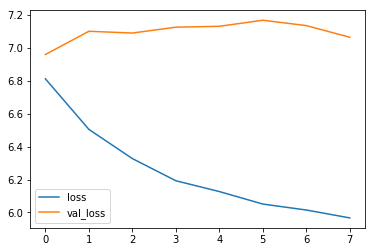

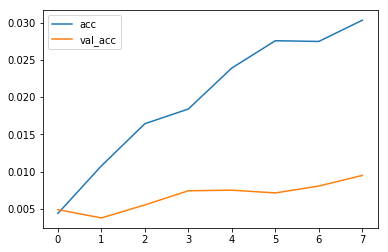

In [18]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

### Test data

In [19]:
test_ann_file = '../input/inaturalist-2019-fgvc6/test2019.json'
with open(test_ann_file) as data_file:
        test_anns = json.load(data_file)

In [20]:
test_img_df = pd.DataFrame(test_anns['images'])[['id', 'file_name']].rename(columns={'id':'image_id'})
test_img_df.head()

,image_id,file_name
0,268243,test2019/e295f3c7046b1f1e80c0301401324aa9.jpg
1,268244,test2019/ad3dcbb6846ed0b4dab58d7b1a4210ba.jpg
2,268245,test2019/e697be8e296b4b140cff4f96f85c364f.jpg
3,268246,test2019/7e7ba55e6aa26ba99e814d63b15d0121.jpg
4,268247,test2019/6cb6372079d23702511c06923970f13f.jpg


In [21]:
%%time

test_generator = test_datagen.flow_from_dataframe(      
    
        dataframe=test_img_df,    
    
        directory = "../input/inaturalist-2019-fgvc6/test2019",    
        x_col="file_name",
        target_size = (img_size,img_size),
        batch_size = 1,
        shuffle = False,
        class_mode = None
        )

Found 35350 images.
CPU times: user 1.5 s, sys: 796 ms, total: 2.29 s
Wall time: 11.5 s


### Prediction

In [22]:
%%time
test_generator.reset()
predict=model_final.predict_generator(test_generator, steps = len(test_generator.filenames))

CPU times: user 41min 19s, sys: 1min 12s, total: 42min 32s
Wall time: 40min 59s


In [23]:
len(predict)

35350

In [24]:
predicted_class_indices=np.argmax(predict,axis=1)

In [25]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [26]:
sam_sub_df = pd.read_csv('../input/inaturalist-2019-fgvc6/kaggle_sample_submission.csv')
sam_sub_df.head()

,id,predicted
0,268243,842
1,268244,139
2,268245,988
3,268246,612
4,268247,468


In [27]:
filenames=test_generator.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted":predictions})
df_res = pd.merge(test_img_df, results, on='file_name')[['image_id','predicted']]\
    .rename(columns={'image_id':'id'})

df_res.head()

,id,predicted
0,268243,285
1,268244,320
2,268245,976
3,268246,373
4,268247,434


In [28]:
df_res.to_csv("submission.csv",index=False)